In [1]:
import os
import yaml
import pandas as pd
import sqlalchemy

import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import display 
pd.options.display.max_columns = None
%matplotlib inline

In [5]:
def connect(poolclass=sqlalchemy.pool.QueuePool):
    with open(os.path.join(os.path.join('../..', 'config'), 'db_default_profile.yaml')) as fd:
        config = yaml.load(fd)
        dburl = sqlalchemy.engine.url.URL(
            "postgres",
            host='kit-tmp-4x.cjtbxnsr2fzp.us-west-2.rds.amazonaws.com',
            username='postgres',
            database='donors_choose',
            password='XXXXXX',
            port=5432,
        )
        return sqlalchemy.create_engine(dburl, poolclass=poolclass)

conn = connect()

In [3]:
import RecallAdjuster as ra

In [6]:
sql = """
WITH mg_rns AS (
  SELECT *,
         row_number() OVER (PARTITION BY train_end_time, list_size, metric, parameter ORDER BY base_value DESC, base_max_recall_ratio ASC, RANDOM()) AS rn_base,
         row_number() OVER (PARTITION BY train_end_time, list_size, metric, parameter ORDER BY adj_value DESC, adj_max_recall_ratio ASC, RANDOM()) AS rn_adj
  FROM kit_bias_all.model_adjustment_results_plevel
  WHERE past_train_end_time = train_end_time
)
, base_mgs AS (
  SELECT * FROM mg_rns WHERE rn_base = 1
)
, adj_mgs AS (
  SELECT * FROM mg_rns WHERE rn_adj = 1
)
-- Simple model selection on last time period, baseline with no recall adjustments
SELECT 'Best Unadjusted Metric - Unadjusted'::VARCHAR(128) AS strategy,
       r.train_end_time, r.past_train_end_time,
       r.list_size, r.metric, r.parameter,
       r.base_value AS value,
       r.base_max_recall_ratio AS max_recall_ratio,
       r.base_recall_not_highest_to_highest AS recall_not_highest_to_highest,
       r.base_frac_not_highest AS frac_not_highest,
       r.base_frac_highest AS frac_highest
FROM kit_bias_all.model_adjustment_results_plevel r
JOIN base_mgs b
  ON r.model_group_id = b.model_group_id
  AND r.past_train_end_time = b.train_end_time
  AND r.list_size = b.list_size
  AND r.metric = b.metric
  AND r.parameter = b.parameter
WHERE r.train_end_time > r.past_train_end_time

UNION ALL

-- Model selection on last time before adjustment, with adjustment applied
SELECT 'Best Unadjusted Metric - Adjusted'::VARCHAR(128) AS strategy,
       r.train_end_time, r.past_train_end_time,
       r.list_size, r.metric, r.parameter,
       r.adj_value AS value,
       r.adj_max_recall_ratio AS max_recall_ratio,
       r.adj_recall_not_highest_to_highest AS recall_not_highest_to_highest,
       r.adj_frac_not_highest AS frac_not_highest,
       r.adj_frac_highest AS frac_highest
FROM kit_bias_all.model_adjustment_results_plevel r
JOIN base_mgs b
  ON r.model_group_id = b.model_group_id
  AND r.past_train_end_time = b.train_end_time
  AND r.list_size = b.list_size
  AND r.metric = b.metric
  AND r.parameter = b.parameter
WHERE r.train_end_time > r.past_train_end_time

UNION ALL

-- Model selection on last time after adjustment, with adjustment applied
SELECT 'Best Adjusted Metric - Adjusted'::VARCHAR(128) AS strategy,
       r.train_end_time, r.past_train_end_time,
       r.list_size, r.metric, r.parameter,
       r.adj_value AS value,
       r.adj_max_recall_ratio AS max_recall_ratio,
       r.adj_recall_not_highest_to_highest AS recall_not_highest_to_highest,
       r.adj_frac_not_highest AS frac_not_highest,
       r.adj_frac_highest AS frac_highest
FROM kit_bias_all.model_adjustment_results_plevel r
JOIN adj_mgs b
  ON r.model_group_id = b.model_group_id
  AND r.past_train_end_time = b.train_end_time
  AND r.list_size = b.list_size
  AND r.metric = b.metric
  AND r.parameter = b.parameter
WHERE r.train_end_time > r.past_train_end_time

UNION ALL

-- Composite model
SELECT 'Composite Model - Adjusted'::VARCHAR(128) AS strategy,
      train_end_time, past_train_end_time,
      list_size, metric, parameter,
      value,
      max_recall_ratio,
      recall_not_highest_to_highest,
      frac_not_highest,
      frac_highest
FROM kit_bias_all.composite_results_plevel
WHERE train_end_time > past_train_end_time
;
"""

In [7]:
ts_df3 = pd.read_sql(sql, conn)

In [10]:
import matplotlib.dates as mdates

months = mdates.MonthLocator([4,8,12])  # every month
months_fmt = mdates.DateFormatter('%b %y')

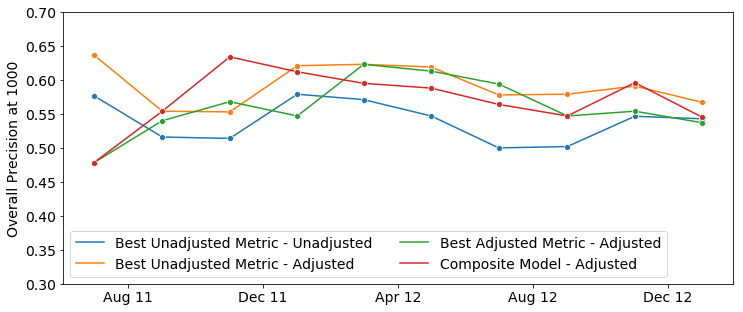

In [16]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df3, x='train_end_time', y='value', hue='strategy', marker="o", ax=ax)

ax.set_ylim((0.30,0.70))
ax.set_ylabel('Overall Precision at 1000', fontsize=14)
ax.set_xlabel('')

ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(months_fmt)

ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

handles, labels = ax.get_legend_handles_labels()
hhandles = []
llabels = []
for i, lab in enumerate(labels):
    if lab not in ('strategy'):
        llabels.append(lab)
        hhandles.append(handles[i])
ax.legend(hhandles, llabels, ncol=2, fontsize=14)


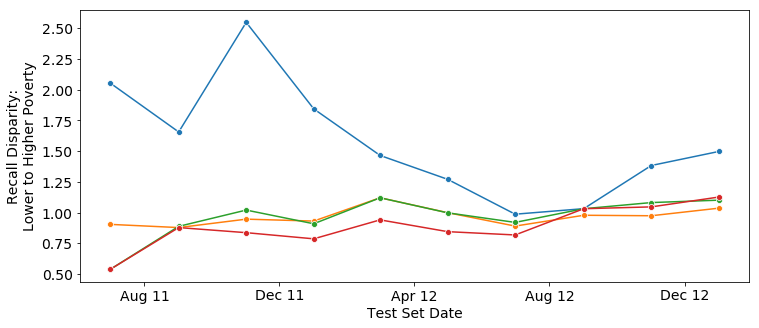

In [14]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df3, x='train_end_time', y='recall_not_highest_to_highest', hue='strategy', marker="o", ax=ax)

ax.set_ylabel('Recall Disparity:\nLower to Higher Poverty', fontsize=14)
ax.set_xlabel('Test Set Date', fontsize=14)

ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(months_fmt)

ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

ax.get_legend().remove()

In [19]:
ts_df3['dataset'] = 'Education Crowdfunding'

comp_df = ts_df3.rename(
    {'recall_not_highest_to_highest': 'recall_disp', 
     'frac_not_highest': 'frac_grp1', 
     'frac_highest': 'frac_grp2'
    }, axis='columns')

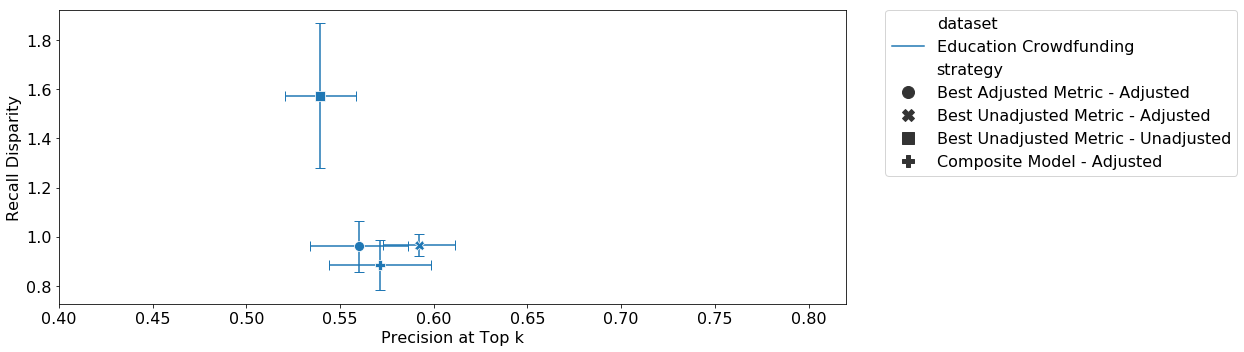

In [20]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=comp_df.groupby(['dataset', 'strategy'])[['value', 'recall_disp']].mean().reset_index(), 
              x='value', y='recall_disp', 
              hue='dataset', 
#              marker="o", 
              style='strategy',
              markers=True,
#              color='dodgerblue',
              markersize=10,
              dashes=None,
              ci=None,
              ax=ax)


for i, ds in enumerate(comp_df['dataset'].unique()):
    tmp_df = comp_df.loc[comp_df['dataset'] == ds, ].copy()
    
    x_coords = list(tmp_df.groupby(['dataset', 'strategy'])[['value', 'recall_disp']].mean().reset_index()['value'].values)
    y_coords = list(tmp_df.groupby(['dataset', 'strategy'])[['value', 'recall_disp']].mean().reset_index()['recall_disp'].values)

    prec_errors = 1.96*tmp_df.groupby(['dataset', 'strategy'])['value'].sem().values
    disp_errors = 1.96*tmp_df.groupby(['dataset', 'strategy'])['recall_disp'].sem().values
    colors = sns.color_palette().as_hex()[i]
    ax.errorbar(x_coords, y_coords, 
                xerr=prec_errors, 
                yerr=disp_errors,
        ecolor=colors, 
        fmt=' ', zorder=-1, capsize=5)


ax.set_xlim((0.40,0.82))

ax.set_ylabel('Recall Disparity', fontsize=16)
ax.set_xlabel('Precision at Top k', fontsize=16)

ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)


handles, labels = ax.get_legend_handles_labels()
hhandles = []
llabels = []
for i, lab in enumerate(labels):
    if lab not in list(comp_df['dataset'].unique()) + ['dataset', 'strategy']:
        handles[i].set_linestyle("")
    hhandles.append(handles[i])
    llabels.append(lab)
ax.legend(hhandles, llabels, fontsize=16, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., markerscale=2)

fig.tight_layout()

In [21]:
comp_df.to_csv('donors_all_mgs_20200612.csv', index=False)

In [22]:
res_adj_df = pd.read_sql('SELECT * FROM kit_bias_all.model_adjustment_results_plevel', conn)
res_comp_df = pd.read_sql('SELECT * FROM kit_bias_all.composite_results_plevel', conn)

In [26]:
res_adj_df.to_csv('donors_all_mgs_model_results.csv', index=False)
res_comp_df.to_csv('donors_all_mgs_composite_results.csv', index=False)

# El Salvador MinEd

In [28]:
def connect(poolclass=sqlalchemy.pool.QueuePool):
    with open(os.path.join(os.path.join('../..', 'config'), 'db_default_profile.yaml')) as fd:
        config = yaml.load(fd)
        dburl = sqlalchemy.engine.url.URL(
            "postgres",
            host='kit-tmp-4x.cjtbxnsr2fzp.us-west-2.rds.amazonaws.com',
            username='postgres',
            database='el_salvador_mined_education',
            password='BONESspotSILENTbecame',
            port=5432,
        )
        return sqlalchemy.create_engine(dburl, poolclass=poolclass)

conn = connect()

In [106]:
sql = """
WITH mg_rns AS (
  SELECT *,
         row_number() OVER (PARTITION BY train_end_time, list_size, metric, parameter ORDER BY base_value DESC, base_max_recall_ratio ASC, RANDOM()) AS rn_base,
         row_number() OVER (PARTITION BY train_end_time, list_size, metric, parameter ORDER BY adj_value DESC, adj_max_recall_ratio ASC, RANDOM()) AS rn_adj
  FROM bias_analysis_1year.model_adjustment_results_ovg
  WHERE past_train_end_time = train_end_time
  AND model_group_id NOT IN (
      -- exclude max_features decision trees
      SELECT model_group_id
      FROM model_metadata.model_groups
      WHERE (model_type = 'sklearn.tree.DecisionTreeClassifier' AND hyperparameters->'max_features' != 'null')
    )
)
, base_mgs AS (
  SELECT * FROM mg_rns WHERE rn_base = 1
)
, adj_mgs AS (
  SELECT * FROM mg_rns WHERE rn_adj = 1
)
-- Simple model selection on last time period, baseline with no recall adjustments
SELECT 'Best Unadjusted Metric - Unadjusted'::VARCHAR(128) AS strategy,
       r.train_end_time, r.past_train_end_time,
       r.list_size, r.metric, r.parameter,
       r.base_value AS value,
       r.base_max_recall_ratio AS max_recall_ratio,
       r.base_recall_1_to_0 AS recall_1_to_0,
       r.base_frac_1 AS frac_1,
       r.base_frac_0 AS frac_0
FROM bias_analysis_1year.model_adjustment_results_ovg r
JOIN base_mgs b
  ON r.model_group_id = b.model_group_id
  AND r.past_train_end_time = b.train_end_time
  AND r.list_size = b.list_size
  AND r.metric = b.metric
  AND r.parameter = b.parameter
WHERE r.train_end_time > r.past_train_end_time

UNION ALL

-- Model selection on last time before adjustment, with adjustment applied
SELECT 'Best Unadjusted Metric - Adjusted'::VARCHAR(128) AS strategy,
       r.train_end_time, r.past_train_end_time,
       r.list_size, r.metric, r.parameter,
       r.adj_value AS value,
       r.adj_max_recall_ratio AS max_recall_ratio,
       r.adj_recall_1_to_0 AS recall_1_to_0,
       r.adj_frac_1 AS frac_1,
       r.adj_frac_0 AS frac_0
FROM bias_analysis_1year.model_adjustment_results_ovg r
JOIN base_mgs b
  ON r.model_group_id = b.model_group_id
  AND r.past_train_end_time = b.train_end_time
  AND r.list_size = b.list_size
  AND r.metric = b.metric
  AND r.parameter = b.parameter
WHERE r.train_end_time > r.past_train_end_time

UNION ALL

-- Model selection on last time after adjustment, with adjustment applied
SELECT 'Best Adjusted Metric - Adjusted'::VARCHAR(128) AS strategy,
       r.train_end_time, r.past_train_end_time,
       r.list_size, r.metric, r.parameter,
       r.adj_value AS value,
       r.adj_max_recall_ratio AS max_recall_ratio,
       r.adj_recall_1_to_0 AS recall_1_to_0,
       r.adj_frac_1 AS frac_1,
       r.adj_frac_0 AS frac_0
FROM bias_analysis_1year.model_adjustment_results_ovg r
JOIN adj_mgs b
  ON r.model_group_id = b.model_group_id
  AND r.past_train_end_time = b.train_end_time
  AND r.list_size = b.list_size
  AND r.metric = b.metric
  AND r.parameter = b.parameter
WHERE r.train_end_time > r.past_train_end_time
;
"""

# UNION ALL

# -- Composite model
# SELECT 'Composite Model - Adjusted'::VARCHAR(128) AS strategy,
#       train_end_time, past_train_end_time,
#       list_size, metric, parameter,
#       value,
#       max_recall_ratio,
#       recall_1_to_0,
#       frac_1,
#       frac_0
# FROM bias_analysis_1year.composite_results_ovg
# WHERE train_end_time > past_train_end_time
# ;
# """



# Other model types that don't seem great here, but don't seem to affect the results, so may err on the side of leaving in:
#           OR
#           (model_type = 'sklearn.tree.DecisionTreeClassifier' AND (hyperparameters->'max_depth')::INT < 10)
#           OR
#           (model_type = 'sklearn.tree.DecisionTreeClassifier' AND (hyperparameters->'min_samples_split')::INT < 100)
#           OR
#           (model_type LIKE '%%ScaledLogisticRegression' AND (hyperparameters->'C')::FLOAT < 0.001)


In [107]:
ts_df4 = pd.read_sql(sql, conn)

# exclude 2011 point based on adjustments from 2010 which had no feature data
ts_df4 = ts_df4.loc[ts_df4['train_end_time'] > '2011-01-01', ]

In [108]:
months = mdates.MonthLocator([1])  # every month
months_fmt = mdates.DateFormatter('%b %y')

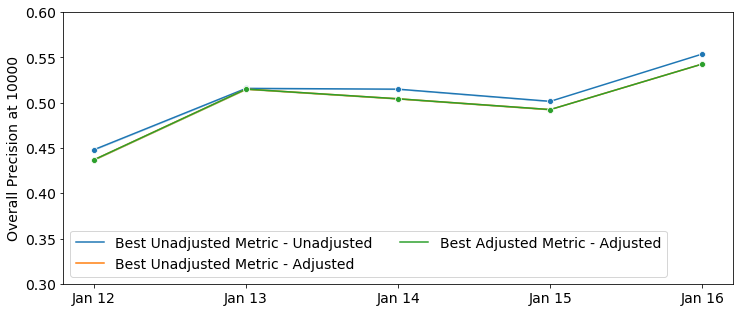

In [109]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df4, x='train_end_time', y='value', hue='strategy', marker="o", ax=ax)

#ax.set_ylim((0.30,0.70))
ax.set_ylim((0.30,0.60))
ax.set_ylabel('Overall Precision at 10000', fontsize=14)
ax.set_xlabel('')

ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(months_fmt)

ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

handles, labels = ax.get_legend_handles_labels()
hhandles = []
llabels = []
for i, lab in enumerate(labels):
    if lab not in ('strategy'):
        llabels.append(lab)
        hhandles.append(handles[i])
ax.legend(hhandles, llabels, ncol=2, fontsize=14)

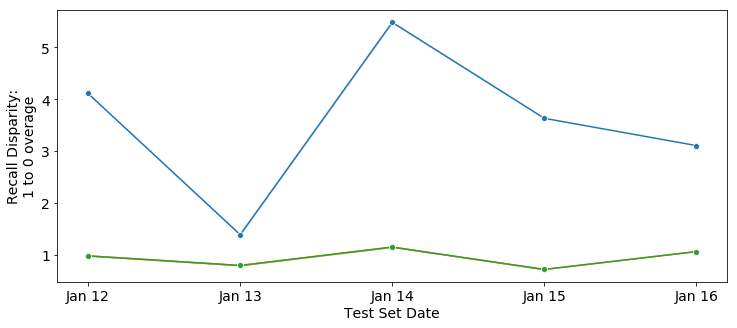

In [110]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df4, x='train_end_time', y='recall_1_to_0', hue='strategy', marker="o", ax=ax)

ax.set_ylabel('Recall Disparity:\n1 to 0 overage', fontsize=14)
ax.set_xlabel('Test Set Date', fontsize=14)

ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(months_fmt)

ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

ax.get_legend().remove()

In [111]:
ts_df4.sort_values('train_end_time')

# Hmmm... overage is around 2% of the lists in general, but jumps to 10% in 2014 and 2015, accounting for the huge
# disparities, possibly reflecting a choice of models that relies particularly heavily on this feature in those years?

# Also worry a little bit about the fairly small baseline size of the group here, though with the large value of k,
# it's probably less troublesome as the raw numbers aren't as small or prone to statistical variation.

,strategy,train_end_time,past_train_end_time,list_size,metric,parameter,value,max_recall_ratio,recall_1_to_0,frac_1,frac_0
30,Best Adjusted Metric - Adjusted,2012-01-01,2011-01-01,10000,precision@,10000_abs,0.436700,1.020006,0.980387,0.0152,0.9848
7,Best Unadjusted Metric - Unadjusted,2012-01-01,2011-01-01,10000,precision@,10000_abs,0.447868,4.119366,4.119366,0.0721,0.9503
8,Best Unadjusted Metric - Unadjusted,2012-01-01,2011-01-01,10000,precision@,10000_abs,0.447868,4.119366,4.119366,0.0721,0.9503
19,Best Unadjusted Metric - Adjusted,2012-01-01,2011-01-01,10000,precision@,10000_abs,0.436700,1.020006,0.980387,0.0152,0.9848
18,Best Unadjusted Metric - Adjusted,2012-01-01,2011-01-01,10000,precision@,10000_abs,0.436700,1.020006,0.980387,0.0152,0.9848
29,Best Adjusted Metric - Adjusted,2012-01-01,2011-01-01,10000,precision@,10000_abs,0.436700,1.020006,0.980387,0.0152,0.9848
28,Best Adjusted Metric - Adjusted,2013-01-01,2012-01-01,10000,precision@,10000_abs,0.514900,1.258693,0.794475,0.0208,0.9792
27,Best Adjusted Metric - Adjusted,2013-01-01,2012-01-01,10000,precision@,10000_abs,0.514900,1.258693,0.794475,0.0208,0.9792
5,Best Unadjusted Metric - Unadjusted,2013-01-01,2012-01-01,10000,precision@,10000_abs,0.515711,1.388356,1.388356,0.0372,0.9748
6,Best Unadjusted Metric - Unadjusted,2013-01-01,2012-01-01,10000,precision@,10000_abs,0.515711,1.388356,1.388356,0.0372,0.9748


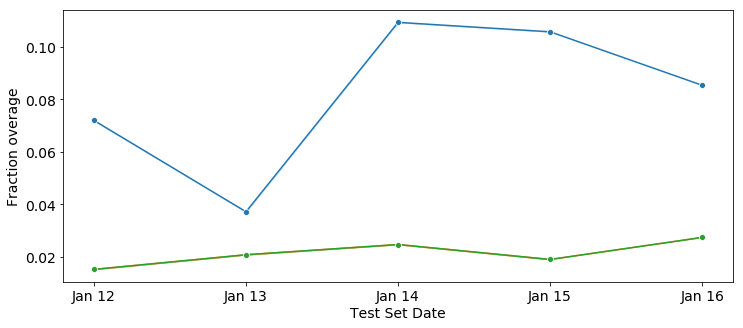

In [112]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df4, x='train_end_time', y='frac_1', hue='strategy', marker="o", ax=ax)

ax.set_ylabel('Fraction overage', fontsize=14)
ax.set_xlabel('Test Set Date', fontsize=14)

ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(months_fmt)

ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

ax.get_legend().remove()

In [113]:
ts_df4['dataset'] = 'Student Outcomes'

comp_df = ts_df4.rename(
    {'recall_1_to_0': 'recall_disp', 
     'frac_1': 'frac_grp1', 
     'frac_0': 'frac_grp2'
    }, axis='columns')

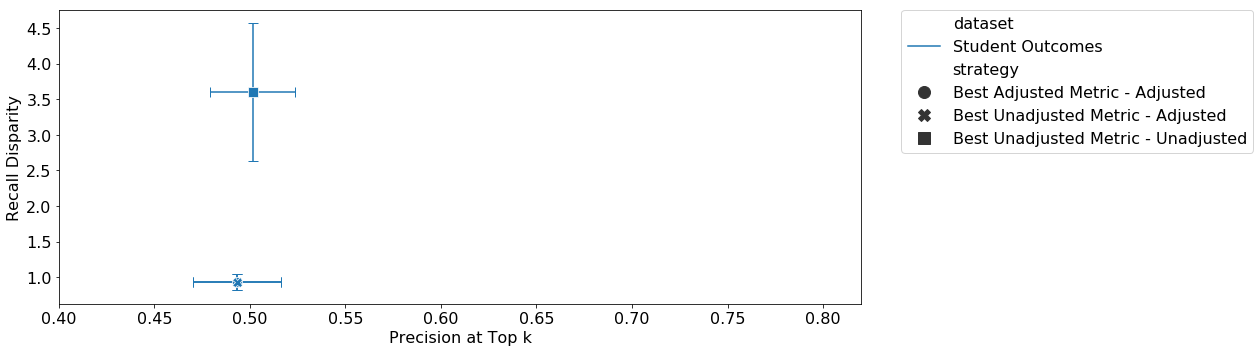

In [114]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=comp_df.groupby(['dataset', 'strategy'])[['value', 'recall_disp']].mean().reset_index(), 
              x='value', y='recall_disp', 
              hue='dataset', 
#              marker="o", 
              style='strategy',
              markers=True,
#              color='dodgerblue',
              markersize=10,
              dashes=None,
              ci=None,
              ax=ax)


for i, ds in enumerate(comp_df['dataset'].unique()):
    tmp_df = comp_df.loc[comp_df['dataset'] == ds, ].copy()
    
    x_coords = list(tmp_df.groupby(['dataset', 'strategy'])[['value', 'recall_disp']].mean().reset_index()['value'].values)
    y_coords = list(tmp_df.groupby(['dataset', 'strategy'])[['value', 'recall_disp']].mean().reset_index()['recall_disp'].values)

    prec_errors = 1.96*tmp_df.groupby(['dataset', 'strategy'])['value'].sem().values
    disp_errors = 1.96*tmp_df.groupby(['dataset', 'strategy'])['recall_disp'].sem().values
    colors = sns.color_palette().as_hex()[i]
    ax.errorbar(x_coords, y_coords, 
                xerr=prec_errors, 
                yerr=disp_errors,
        ecolor=colors, 
        fmt=' ', zorder=-1, capsize=5)


ax.set_xlim((0.40,0.82))

ax.set_ylabel('Recall Disparity', fontsize=16)
ax.set_xlabel('Precision at Top k', fontsize=16)

ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)


handles, labels = ax.get_legend_handles_labels()
hhandles = []
llabels = []
for i, lab in enumerate(labels):
    if lab not in list(comp_df['dataset'].unique()) + ['dataset', 'strategy']:
        handles[i].set_linestyle("")
    hhandles.append(handles[i])
    llabels.append(lab)
ax.legend(hhandles, llabels, fontsize=16, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., markerscale=2)

fig.tight_layout()